# 指数重み付き移動平均
## EWMA[0] = S[0]

## EWMA[t] = αS[t] + (1-α)EWMA[t-1]
### t∈{1,…,T}

In [38]:
import numpy as np
import pandas as pd
import numba
%load_ext Cython
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

sym = 'SPY'
alpha = 0.25

In [21]:
data = pd.DataFrame(pd.read_csv('D:\ダウンロード/tr_eikon_eod_data.csv',
                               index_col=0, parse_dates=True)[sym]).dropna()
#dropnaで欠損値を削除

In [22]:
data['EWMA'] = data[sym]

In [23]:
%%time
for t in zip(data.index, data.index[1:]):
    data.loc[t[1], 'EWMA'] = (alpha * data.loc[t[1], sym] +
    (1 - alpha) * data.loc[t[0], 'EWMA'])

Wall time: 650 ms


In [24]:
data.head()

,SPY,EWMA
Date,,
2010-01-04,113.33,113.330000
2010-01-05,113.63,113.405000
2010-01-06,113.71,113.481250
2010-01-07,114.19,113.658438
2010-01-08,114.57,113.886328


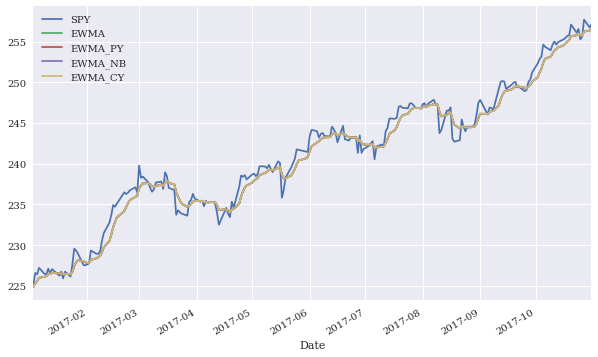

In [46]:
data[data.index > '2017-1-1'].plot(figsize=(10, 6));

## 簡単な関数で

In [26]:
def ewma_py(x, alpha):
    y = np.zeros_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1-alpha) * y[i-1]
    return y

In [27]:
%time data['EWMA_PY'] = ewma_py(data[sym], alpha) 
#時系列オブジェクトに関数を使った場合

Wall time: 56.8 ms


In [28]:
%time data['EWMA_PY'] = ewma_py(data[sym].values, alpha)
#ndarrrayオブジェクトに関数を使った場合

Wall time: 2.99 ms


## Numba

In [31]:
ewma_nb = numba.jit(ewma_py)

In [44]:
%time data['EWMA_NB'] = ewma_nb(data[sym], alpha)

Wall time: 58.8 ms


In [45]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym], alpha)

32.4 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [34]:
%time data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)

Wall time: 214 ms


In [35]:
%timeit data['EWMA_NB'] = ewma_nb(data[sym].values, alpha)

158 µs ± 9.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Cython

In [51]:
%%cython
import numpy as np #ここでnumpyを再度インポートしないとエラーが出ます
cimport cython
@cython.boundscheck(False) #indexに対するエラーをチェックしない
@cython.wraparound(False) #末尾からのインデックス操作を行わない
def ewma_cy(double[:] x, float alpha): #変数の前で型を宣言する
    cdef int i
    cdef double[:] y = np.empty_like(x)
    y[0] = x[0]
    for i in range(1, len(x)):
        y[i] = alpha * x[i] + (1 - alpha) * y[i - 1]
    return y

In [48]:
%time data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

Wall time: 2 ms


In [49]:
%timeit data['EWMA_CY'] = ewma_cy(data[sym].values, alpha)

665 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


今回はNumbaが一番早い